# Model Evaluations
The purpose of this notebook is to...

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os

sns.set(rc={'figure.figsize':(14,7)})
series_map = pickle.load(open('pickled/series_map.pckl','rb'))
approach_map = {
    'Unadjusted':'orig',
    'IgnoreCOVID':'no_covid',
    'OutlierDetect':'with_outlier_detection'
}

pd.options.display.float_format = '{:,.0f}'.format

In [2]:
future_actuals = pd.read_csv('data/Future Passengers.csv',parse_dates=['DATE'])
future_actuals.set_index('DATE').astype(float)

,HOU-Int,HOU-Dom,IAH-Dom,IAH-Int
DATE,,,,
2021-10-01,"27,153","498,237","1,375,815","285,498"
2021-11-01,"34,242","495,800","1,356,136","336,156"
2021-12-01,"39,101","477,752","1,331,893","417,561"
2022-01-01,"29,084","387,446","1,036,051","287,998"


In [3]:
def compare_all_best_models_total_accr(series_map):
    """
    """
    all_results = pd.DataFrame(columns=approach_map.keys(),index=series_map.keys())
    all_best_models = all_results.copy()
    for series in series_map.keys():
        for apprt, appr in approach_map.items():
            results = pd.read_excel(os.path.join('fcst_results',
                                       '{}_series_{}_results.xlsx'.format(appr,series)),
                                       sheet_name=['lvl_fcsts','model_summaries'])
            best_model = results['model_summaries'].iloc[0,0]
            results_lvl = results['lvl_fcsts']
            results_lvl['DATE'] = pd.to_datetime(results_lvl['DATE'])
            results_lvl = results_lvl.loc[results_lvl['DATE'].isin(future_actuals['DATE'])].reset_index(drop=True)
            all_results.loc[series,apprt] = 1 - np.abs((future_actuals[series].sum() - results_lvl[best_model].sum()) / future_actuals[series].sum())
            all_best_models.loc[series,apprt] = best_model
    all_results.loc['Grand Mean'] = all_results.mean()
    return all_results, all_best_models
        
def compare_all_best_models_mean_accr(series_map):
    """
    """
    all_results = pd.DataFrame(columns=approach_map.keys(),index=series_map.keys())
    for series in series_map.keys():
        for apprt, appr in approach_map.items():
            results = pd.read_excel(os.path.join('fcst_results',
                                       '{}_series_{}_results.xlsx'.format(appr,series)),
                                       sheet_name=['lvl_fcsts','model_summaries'])
            best_model = results['model_summaries'].iloc[0,0]
            results_lvl = results['lvl_fcsts']
            results_lvl['DATE'] = pd.to_datetime(results_lvl['DATE'])
            results_lvl = results_lvl.loc[results_lvl['DATE'].isin(future_actuals['DATE'])].reset_index(drop=True)
            all_results.loc[series,apprt] = 1 - np.mean(np.abs((future_actuals[series] - results_lvl[best_model]) / future_actuals[series]))
    all_results.loc['Grand Mean'] = all_results.mean()
    return all_results

def compare_all_models_total_accr(series_map,model_type):
    """
    """
    best_model = model_type
    all_results = pd.DataFrame(columns=approach_map.keys(),index=series_map.keys())
    for series in series_map.keys():
        for apprt, appr in approach_map.items():
            results_lvl = pd.read_excel(os.path.join('fcst_results',
                                       '{}_series_{}_results.xlsx'.format(appr,series)),
                                       sheet_name='lvl_fcsts',parse_dates=['DATE'])
            results_lvl = results_lvl.loc[results_lvl['DATE'].isin(future_actuals['DATE'])]
            try:
                all_results.loc[series,apprt] = 1 - np.abs((future_actuals[series].sum() - results_lvl[best_model].sum()) / future_actuals[series].sum())
            except KeyError:
                pass
    all_results = all_results.dropna(axis=1)
    all_results.loc['Grand Mean'] = all_results.mean()
    return all_results

def display_results_hm(tbl,t='Total',models='Best Models'):
    """
    """
    sns.heatmap(tbl.iloc[:-1].astype(float),
               vmin=.5,
               vmax=1,
               annot=True,
               fmt='.2%',
               cmap=sns.color_palette("Spectral", as_cmap=True),
               linewidth=2)
    plt.title(f"Different Approaches' {t} Accuracy on New Data - {models}",size=18)
    plt.yticks(rotation = 0,size=16)
    plt.xticks(size=16)
    plt.show()
    return tbl.iloc[-1:,:]

In [4]:
pd.options.display.float_format = '{:.2%}'.format

## Compare all best models

### total accuracy

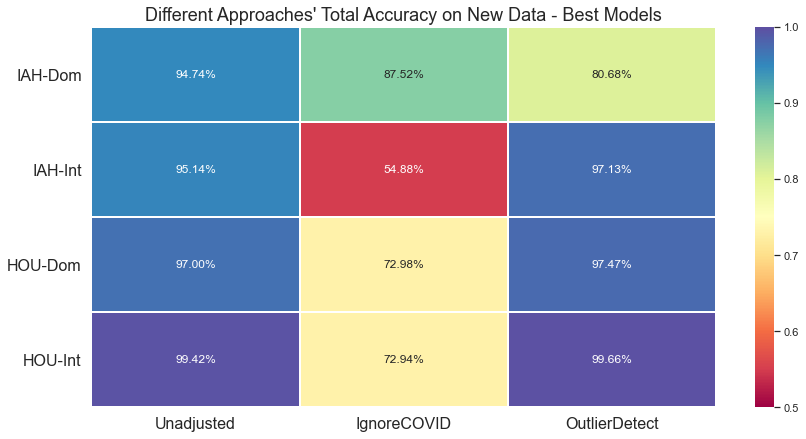

,Unadjusted,IgnoreCOVID,OutlierDetect
Grand Mean,96.58%,72.08%,93.74%


In [5]:
best_models_results = compare_all_best_models_total_accr(series_map)
display_results_hm(best_models_results[0])

### mean accuracy (1-mape)

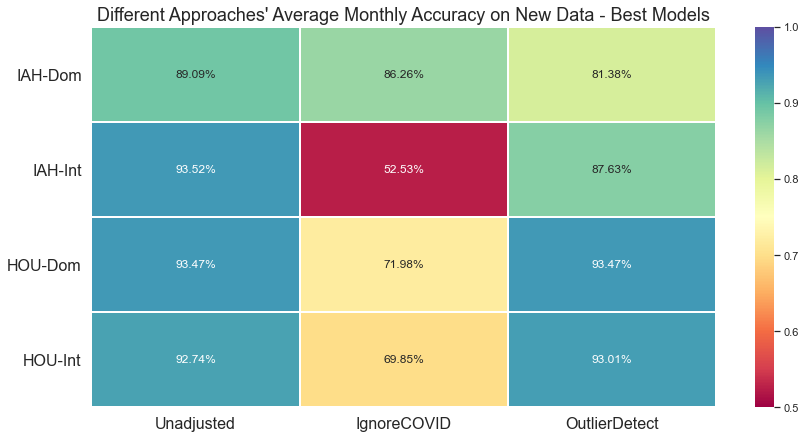

,Unadjusted,IgnoreCOVID,OutlierDetect
Grand Mean,92.21%,70.15%,88.87%


In [6]:
mean_results = compare_all_best_models_mean_accr(series_map)
display_results_hm(mean_results,'Average Monthly')

### selected best models

In [7]:
best_models_results[1]

,Unadjusted,IgnoreCOVID,OutlierDetect
IAH-Dom,weighted_ensemble,arima,prophet
IAH-Int,arima,prophet,arima
HOU-Dom,arima,weighted_ensemble,arima
HOU-Int,arima,lstm_reg,arima


## Compare all ARIMA models

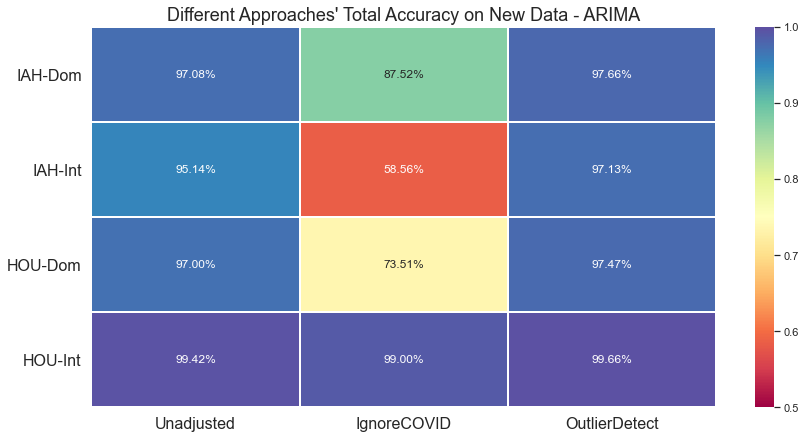

,Unadjusted,IgnoreCOVID,OutlierDetect
Grand Mean,97.16%,79.65%,97.98%


In [8]:
arima_results = compare_all_models_total_accr(series_map,'arima')
display_results_hm(arima_results,models='ARIMA')

## Compare all Prophet models

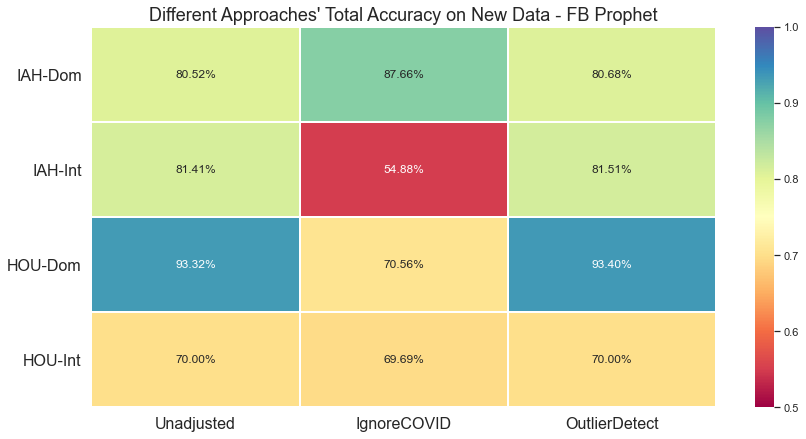

,Unadjusted,IgnoreCOVID,OutlierDetect
Grand Mean,81.31%,70.70%,81.40%


In [9]:
prophet_results = compare_all_models_total_accr(series_map,'prophet')
display_results_hm(prophet_results,models='FB Prophet')

## Compare all LSTM models

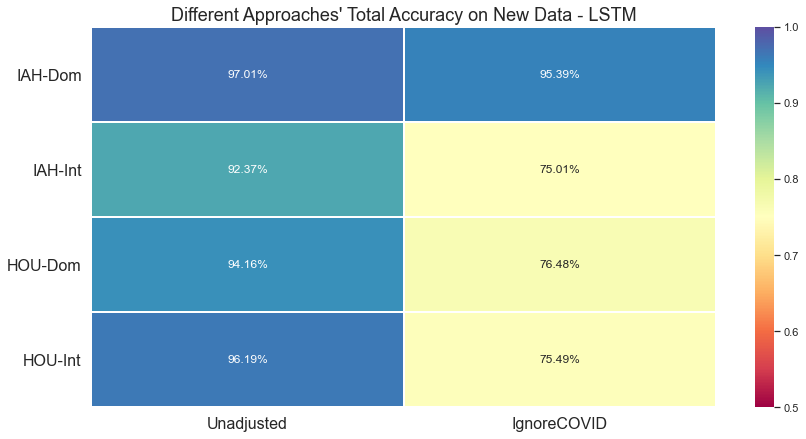

,Unadjusted,IgnoreCOVID
Grand Mean,94.93%,80.59%


In [10]:
lstm_results = compare_all_models_total_accr(series_map,'lstm')
display_results_hm(lstm_results,models='LSTM')

## Compare all regularized LSTM models

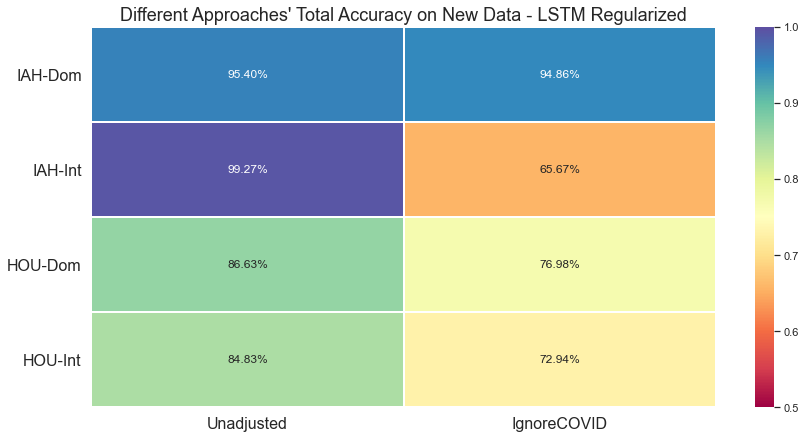

,Unadjusted,IgnoreCOVID
Grand Mean,91.53%,77.61%


In [11]:
lstm_reg_results = compare_all_models_total_accr(series_map,'lstm_reg')
display_results_hm(lstm_reg_results,models='LSTM Regularized')

## Compare all Ensemble models

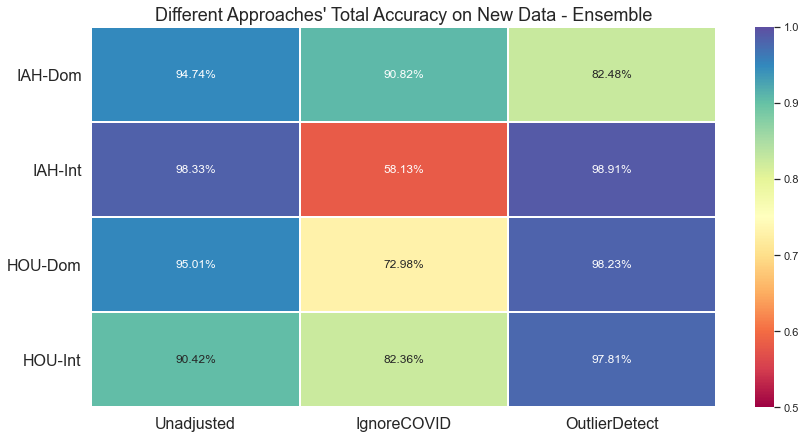

,Unadjusted,IgnoreCOVID,OutlierDetect
Grand Mean,94.62%,76.07%,94.36%


In [12]:
ens_results = compare_all_models_total_accr(series_map,'weighted_ensemble')
display_results_hm(ens_results,models='Ensemble')